In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_bbox = np.load('/content/drive/MyDrive/helen_finale/data_bbox_screen.npy',)
data_names = np.load('/content/drive/MyDrive/helen_finale/data_names_screen.npy')
data_attenction = np.load('/content/drive/MyDrive/helen_finale/data_attenction_screen.npy')
print(data_bbox.size)
print(data_names.size)
print(data_bbox[1])
print(data_attenction.size)

112608
1173
[[339 355]
 [326 342]
 [316 356]
 [328 370]
 [224 349]
 [214 336]
 [206 350]
 [216 363]
 [178 226]
 [534 614]
 [534 226]
 [178 614]
 [252 230]
 [298 226]
 [344 226]
 [397 232]
 [441 247]
 [480 270]
 [507 296]
 [526 331]
 [532 368]
 [534 407]
 [531 448]
 [517 492]
 [490 529]
 [458 557]
 [424 580]
 [396 595]
 [370 607]
 [344 614]
 [317 614]
 [296 608]
 [284 596]
 [277 581]
 [270 565]
 [261 544]
 [256 518]
 [251 485]
 [243 446]
 [235 410]
 [228 376]
 [216 345]
 [199 314]
 [189 290]
 [182 267]
 [183 249]
 [196 239]
 [218 233]]
1173


0


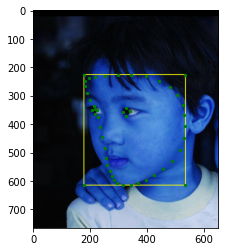

In [4]:
im=cv2.imread(('/content/drive/MyDrive/helen_finale/screen/'+data_names[1]))
plt.imshow(im)
plt.scatter(data_bbox[1][:,0], data_bbox[1][:,1], s = 5, c = 'g') 
plt.imshow(cv2.rectangle(im, (data_bbox[1][8,0], data_bbox[1][8,1]), (data_bbox[1][9,0], data_bbox[1][9,1]), (255, 255, 0), 2))
print(data_attenction[1])

In [5]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.2, 
                                              contrast=0.2,
                                              saturation=0.2, 
                                              hue=0.3)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks,crops):
        left = int(crops[0])
        top =  int(crops[1])
        width = int(crops[2])
        height = int(crops[3])


       # image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) # - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [6]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, df_names, df_bbox, transform=None):

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        
        for filename in df_names:
            self.image_filenames.append("/content/drive/MyDrive/helen_finale/screen/"+filename)
            
        posizione=0
        for num in df_bbox:
             landmark = []
             crop=[]
             for i in range(48):
               if(i<8 or i>9):
                  x_coordinate = int(num[i][0])
                  y_coordinate = int(num[i][1])
                  landmark.append([x_coordinate, y_coordinate])
             if(data_attenction[posizione]==1):
               landmark.append([0, 500])   
             else:
               landmark.append([0, 0])
             self.landmarks.append(landmark)

             
             crop.append(int(num[8][0]))
             crop.append(int(num[8][1]))
             crop.append((int(num[9][0])-int(num[8][0])))
             crop.append((int(num[9][1])-int(num[8][1])))

             self.crops.append(crop)

             posizione+=1
            
        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        #print(self.image_filenames[index])
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(data_names,data_bbox,Transforms())
#qua metti la cosa per il test set fatta da te con le tue foto

tensor([[117.3220, 104.4858],
        [113.3000, 100.2126],
        [109.4357, 103.9107],
        [113.0842, 108.4372],
        [ 78.2435,  98.4085],
        [ 75.2459,  94.2483],
        [ 72.0647,  98.0217],
        [ 75.0623, 102.1819],
        [188.0528,  74.2848],
        [ 54.0291, 173.8033],
        [ 91.6249,  64.8286],
        [107.4617,  65.3968],
        [123.1701,  67.1292],
        [141.0764,  70.8715],
        [155.6204,  76.8943],
        [168.2002,  85.0572],
        [176.5858,  93.6412],
        [181.9506, 104.5434],
        [182.8119, 115.5380],
        [182.2431, 126.9641],
        [179.9026, 138.7840],
        [173.7094, 151.0628],
        [163.3016, 160.8146],
        [151.4753, 167.7588],
        [139.1264, 173.1723],
        [129.0833, 176.4835],
        [119.8195, 178.9969],
        [110.7161, 180.0550],
        [101.4959, 179.0382],
        [ 94.5173, 176.5010],
        [ 90.8046, 172.5565],
        [ 88.8956, 167.9272],
        [ 87.0188, 163.0069],
        [ 

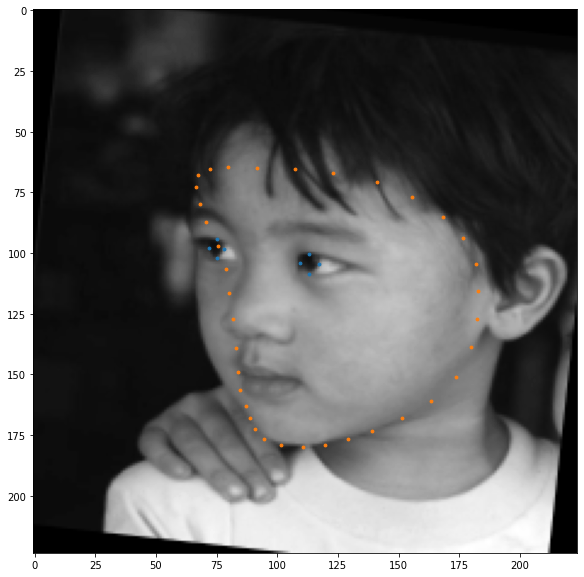

In [7]:
image, landmarks = dataset[1]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:8,0], landmarks[:8,1], s=8);  
plt.scatter(landmarks[10:46,0], landmarks[10:46,1], s=8);

print(landmarks) 

In [8]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_test_set = int(0.07*len(dataset))
len_train_set = len(dataset) - len_valid_set -len_test_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))

train_dataset , valid_dataset, test_dataset= torch.utils.data.random_split(dataset , [len_train_set, len_valid_set, len_test_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2) #64->16
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=82, shuffle=True, num_workers=2) #64->16
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=2) 

The length of Train set is 974
The length of Valid set is 117
The length of Test set is 82


In [9]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([16, 1, 224, 224])
torch.Size([16, 47, 2])


In [10]:
class Network(nn.Module):
    def __init__(self,num_classes=94): #num_classe 16->1
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) 
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [11]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

Valid Steps: 15/15  Loss: 0.0257 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0036  Valid Loss: 0.0257
--------------------------------------------------

Minimum Validation Loss of 0.0257 at epoch 1/50
Model Saved

Valid Steps: 15/15  Loss: 0.0030 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0029  Valid Loss: 0.0030
--------------------------------------------------

Minimum Validation Loss of 0.0030 at epoch 2/50
Model Saved

Valid Steps: 15/15  Loss: 0.0026 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0026  Valid Loss: 0.0026
--------------------------------------------------

Minimum Validation Loss of 0.0026 at epoch 3/50
Model Saved

Valid Steps: 15/15  Loss: 0.0045 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0022  Valid Loss: 0.0045
--------------------------------------------------
Valid Steps: 15/15  Loss: 0.0026 
----------------------------------------

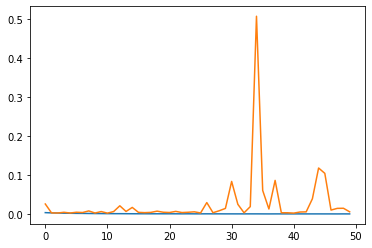

In [12]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

state= torch.load("/content/drive/MyDrive/helen_finale/Soluzione_resnet34_noCrop_secondoGiro_imgRuotate90.pth") #per secondo giro
network.load_state_dict(state) #per secondo giro

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 50

loss_train_graph=[]
loss_valid_graph=[]

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating themdeep-learning pytorch

        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    loss_train_graph.append(loss_train)
    loss_valid_graph.append(loss_valid)

    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')

torch.save(network.state_dict(), '/content/ultimo.pth')      
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

plt.plot(loss_train_graph)

plt.plot(loss_valid_graph)

Mediapipe dice attento
Pytorch dice attento
attento
Mediapipe dice attento
Pytorch dice attento
attento
Mediapipe dice attento
Pytorch dice attento
left
Mediapipe dice attento
Pytorch dice attento
attento
Mediapipe dice attento
Pytorch dice attento
attento
Mediapipe dice attento
Pytorch dice attento
right
Mediapipe dice attento
Pytorch dice attento
attento
Mediapipe dice attento
Pytorch dice attento
left


accuracy dell'attention regola base è {} 0.9512195121951219
accuracy dell'attention regola geometrica è {} 0.5121951219512195


accuracy del landamark è {} 0.9802956261955695
Total number of test images: 82
Elapsed Time : 34.95081400871277


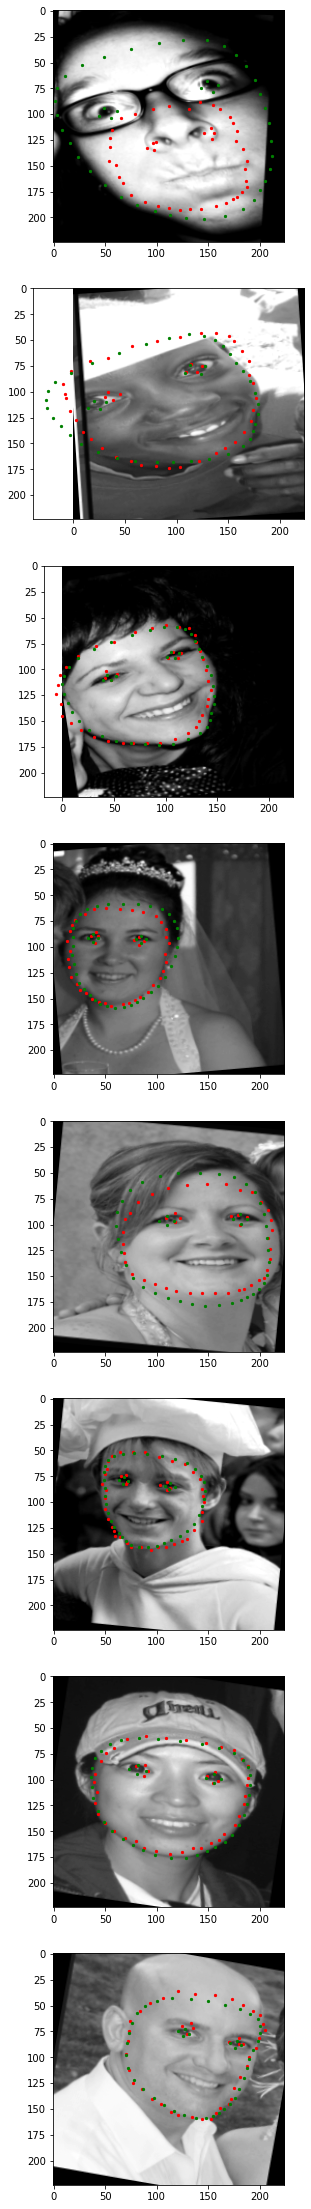

In [13]:
import math

start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/Soluzione_resnet34_noCrop_terzoGiro_Screen.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(test_loader))
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224
                   
    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,47,2) #secondo 16->1

    plt.figure(figsize=(10,40))
    mediapipe=""
    pytorch=""
    giusti=[]
    predetti=[]
    valore_base=0
    valore_geom=0
    numeri_att=[17,39,0,6]
    

    for img_num in range(82): #da cambiare in base alla grandezza del test set
        if img_num<8:
          plt.subplot(8,1,img_num+1)
          plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
          plt.scatter(predictions[img_num,:8,0], predictions[img_num,:8,1], c = 'r', s = 5)
          plt.scatter(landmarks[img_num,:8,0], landmarks[img_num,:8,1], c = 'g', s = 5)
          plt.scatter(predictions[img_num,10:46,0], predictions[img_num,10:46,1], c = 'r', s = 5)
          plt.scatter(landmarks[img_num,10:46,0], landmarks[img_num,10:46,1], c = 'g', s = 5)
          #plt.scatter(landmarks[img_num,17,0], landmarks[img_num,17,1], c = 'g', s = 5)
          #plt.scatter(landmarks[img_num,39,0], landmarks[img_num,39,1], c = 'g', s = 5)
          #plt.scatter(landmarks[img_num,0,0], landmarks[img_num,0,1], c = 'g', s = 5)
          #plt.scatter(landmarks[img_num,6,0], landmarks[img_num,6,1], c = 'g', s = 5)
          
        
        for i in range(46):
          giusti.append(landmarks[img_num,i,0].item())
          giusti.append(landmarks[img_num,i,1].item())
          predetti.append(predictions[img_num,i,0].item())
          predetti.append(predictions[img_num,i,1].item())
              
        distance_r=math.sqrt((predictions[img_num,17,0].item()-predictions[img_num,0,0].item())**2+(predictions[img_num,17,1].item()-predictions[img_num,0,1].item())**2)
        distance_l=math.sqrt((predictions[img_num,39,0].item()-predictions[img_num,6,0].item())**2+(predictions[img_num,39,1].item()-predictions[img_num,6,1].item())**2)
        dist=distance_r/distance_l

        if((landmarks[img_num,46,1]).item()>0):
          if img_num<8: 
            print("Mediapipe dice attento")
          mediapipe="attento"
        else:
          if img_num<8: 
            print("Mediapipe dice di no")
          mediapipe="no"
        
        if((predictions[img_num,46,1]).item()>0):
          if img_num<8: 
            print("Pytorch dice attento")
          pytorch="attento"
        else:
          if img_num<8: 
            print("Pytorch dice di no")  
          pytorch="no"  
  
        if(pytorch==mediapipe):
          valore_base+=1
              
        dist=distance_r/distance_l
        if dist>1.5:
          if img_num<8: 
            print("right")
          pytorch="no"  
        elif(dist<0.5):
          if img_num<8: 
            print("left")
          pytorch="no"  
        else:
          if img_num<8: 
            print("attento")
          pytorch="attento"  
        #print(dist)  
        if(pytorch==mediapipe):
          valore_geom+=1

    print("\n")
        
    print("accuracy dell'attention regola base è {}",valore_base/82)    
    print("accuracy dell'attention regola geometrica è {}",valore_geom/82)   
    print("\n")  
    
    somma=[]
    totale=0
    for i in range(len(giusti)):
      a=(giusti[i]-predetti[i])/224
      if a<0:
        a=-a
      somma.append(a)
    for elem in somma:
      totale+=elem
    totale=totale/82
    totale=1-totale/100 
    print("accuracy del landamark è {}", totale)
print('Total number of test images: {}'.format(len(test_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 